## This notebook explains how to use albumentations for segmentation

We will use images and data from the [TGS Salt Identification Challenge](https://www.kaggle.com/c/tgs-salt-identification-challenge).

In [1]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt

from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomContrast,
    RandomGamma,
    RandomBrightness
)

In [2]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)
        
    

In [3]:
image = cv2.imread('images/kaggle_salt/0fea4b5049_image.png')
mask = cv2.imread('images/kaggle_salt/0fea4b5049.png', 0)

## Original image <a class="anchor" id="original-image"></a>

In [4]:
print(image.shape, mask.shape)

(101, 101, 3) (101, 101)


In [5]:
original_height, original_width = image.shape[:2]

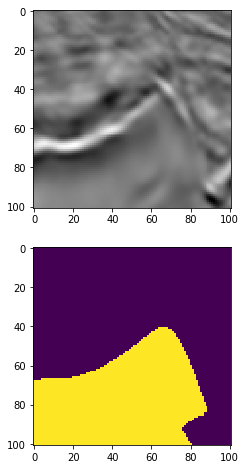

In [6]:
visualize(image, mask)

 # Padding

UNet type architecture require input image size be divisible by $2^N$, where $N$ is th enumber of the maxpooling layers. In the vanilla UNet $N=5$  $\Longrightarrow$ we need to pad input images to the closest divisible by $2^5 = 32$ number which is 128. This operation may be performed using [**PadIfNeeded**](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.PadIfNeeded) transformation. Which pads both image and mask on all four sides. Padding type (zero, constant, reflection) may be specified. Default padding is reflection padding.

(128, 128, 3) (128, 128)


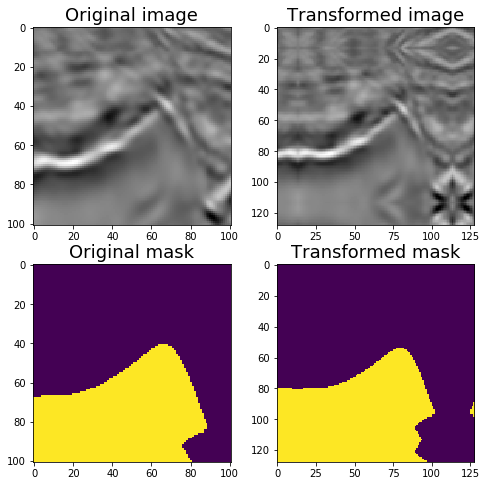

In [7]:
aug = PadIfNeeded(p=1, min_height=128, min_width=128)

augmented = aug(image=image, mask=mask)

image_padded = augmented['image']
mask_padded = augmented['mask']

print(image_padded.shape, mask_padded.shape)

visualize(image_padded, mask_padded, original_image=image, original_mask=mask)

# CenterCrop and Crop

To get to the original image and mask we may use [**CenterCrop**](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.CenterCrop) or [**Crop**](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.Crop) transformations.

(101, 101, 3) (101, 101)


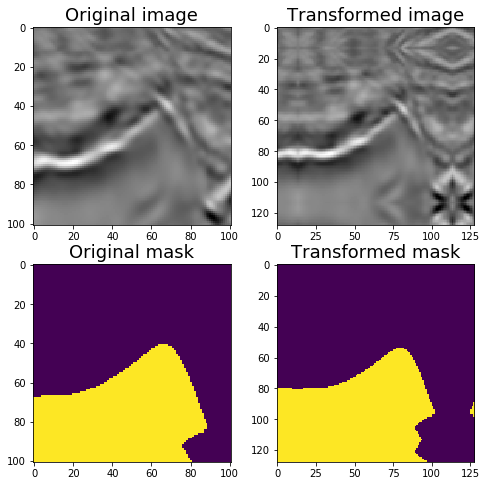

In [8]:
aug = CenterCrop(p=1, height=original_height, width=original_width)

augmented = aug(image=image_padded, mask=mask_padded)

image_center_cropped = augmented['image']
mask_center_cropped = augmented['mask']

print(image_center_cropped.shape, mask_center_cropped.shape)

assert (image - image_center_cropped).sum() == 0
assert (mask - mask_center_cropped).sum() == 0

visualize(image_padded, mask_padded, original_image=image_center_cropped, original_mask=mask_center_cropped)

(101, 101, 3) (101, 101)


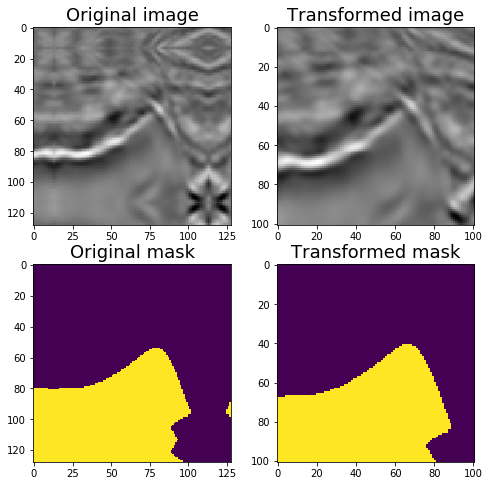

In [9]:
x_min = (128 - original_width) // 2
y_min = (128 - original_height) // 2

x_max = x_min + original_width
y_max = y_min + original_height

aug = Crop(p=1, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)

augmented = aug(image=image_padded, mask=mask_padded)

image_cropped = augmented['image']
mask_cropped = augmented['mask']

print(image_cropped.shape, mask_cropped.shape)

assert (image - image_cropped).sum() == 0
assert (mask - mask_cropped).sum() == 0

visualize(image_cropped, mask_cropped, original_image=image_padded, original_mask=mask_padded)

# Non destructive transformations. [Dehidral group D4](https://en.wikipedia.org/wiki/Dihedral_group)

For images for which there is no clear notion of top like this one, satellite and aerial imagery or medical imagery it is typically a good idea to add transformations that do not add or loose the information.

There are eight distinct ways to represent the same square on the plane.

![D4](https://habrastorage.org/webt/ln/nw/nc/lnnwncjfjsn8zpfo6igvqq-rjky.png)

Combinations of the transformations [HorizontalFlip](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.HorizontalFlip), [VerticalFlip](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.VerticalFlip), [Transpose](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.Transpose), [RandomRotate90](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomRotate90) will be able to get the original image to all eight states.

 ## HorizontalFlip

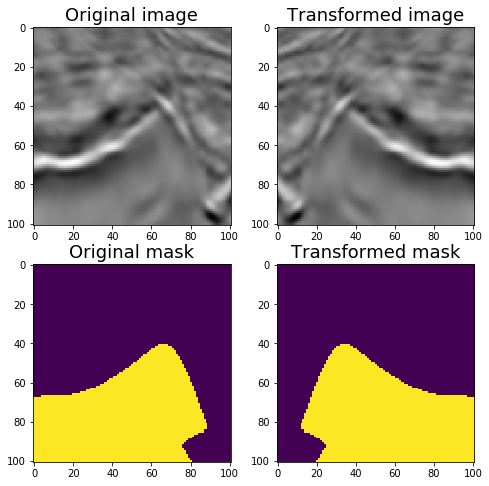

In [10]:
aug = HorizontalFlip(p=1)

augmented = aug(image=image, mask=mask)

image_h_flipped = augmented['image']
mask_h_flipped = augmented['mask']

visualize(image_h_flipped, mask_h_flipped, original_image=image, original_mask=mask)

## VerticalFlip

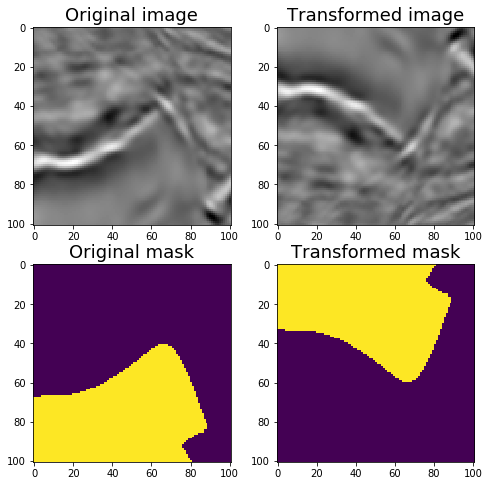

In [11]:
aug = VerticalFlip(p=1)

augmented = aug(image=image, mask=mask)

image_v_flipped = augmented['image']
mask_v_flipped = augmented['mask']

visualize(image_v_flipped, mask_v_flipped, original_image=image, original_mask=mask)

## RandomRotate90 (Randomly rotates by 0, 90, 180, 270 degrees)

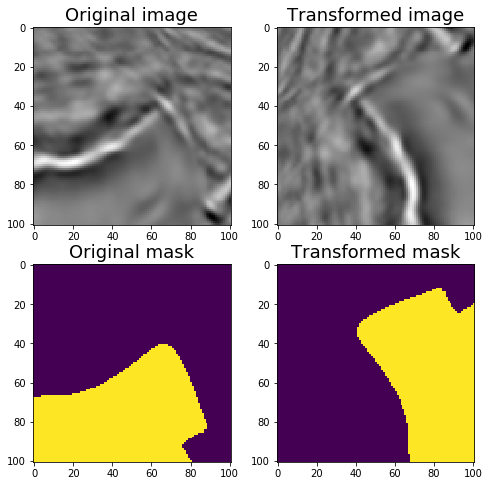

In [12]:
aug = RandomRotate90(p=1)

augmented = aug(image=image, mask=mask)

image_rot90 = augmented['image']
mask_rot90 = augmented['mask']

visualize(image_rot90, mask_rot90, original_image=image, original_mask=mask)

 ## Transpose (switch X and Y axis) 

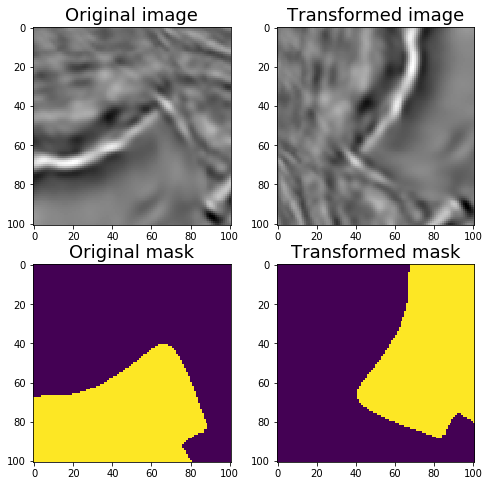

In [13]:
aug = Transpose(p=1)

augmented = aug(image=image, mask=mask)

image_transposed = augmented['image']
mask_transposed = augmented['mask']

visualize(image_transposed, mask_transposed, original_image=image, original_mask=mask)

# Non-rigid transformations: ElasticTransform, GridDistortion, OpticalDistortion

In medical imaging problems non rigind transformations help to augment the data. It is unclear if they will help in this problem, but let's look at them. We will consider [ElasticTransform](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.ElasticTransform), [GridDistortion](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.GridDistortion), [OpticalDistortion](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.OpticalDistortion).

## ElasticTransform

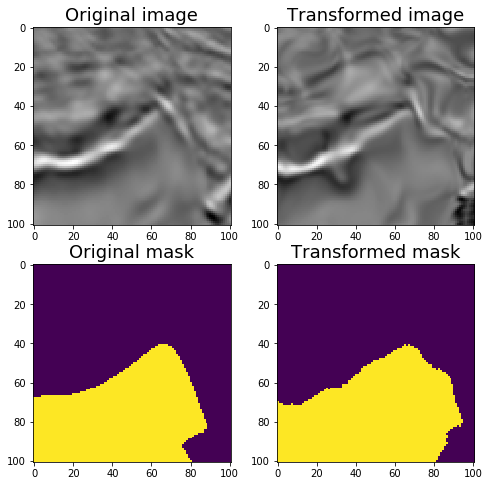

In [14]:
aug = ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)

augmented = aug(image=image, mask=mask)

image_elastic = augmented['image']
mask_elastic = augmented['mask']

visualize(image_elastic, mask_elastic, original_image=image, original_mask=mask)

## GridDistortion

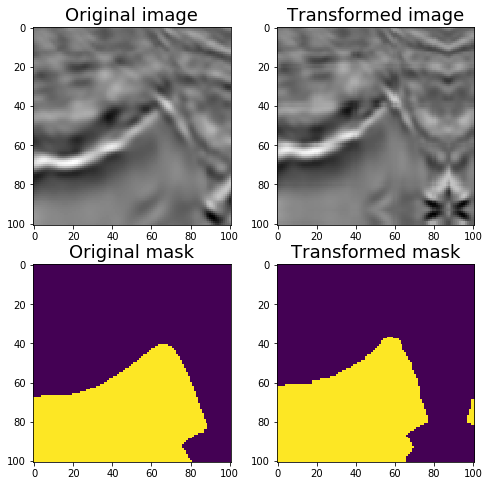

In [15]:
aug = GridDistortion(p=1)

augmented = aug(image=image, mask=mask)

image_grid = augmented['image']
mask_grid = augmented['mask']

visualize(image_grid, mask_grid, original_image=image, original_mask=mask)

## OpticalDistortion

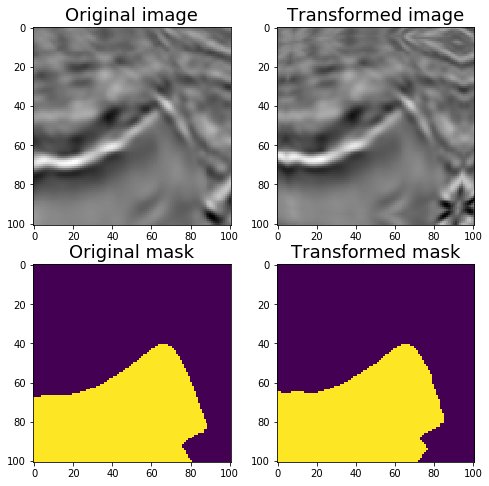

In [17]:
aug = OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)

augmented = aug(image=image, mask=mask)

image_optical = augmented['image']
mask_optical = augmented['mask']

visualize(image_optical, mask_optical, original_image=image, original_mask=mask)

# RandomSizedCrop

One may combine [RandomCrop](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomCrop) and [RandomScale](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomScale) but there is a transformation [RandomSizedCrop](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomSizedCrop) that allows to combine them into one transformation.

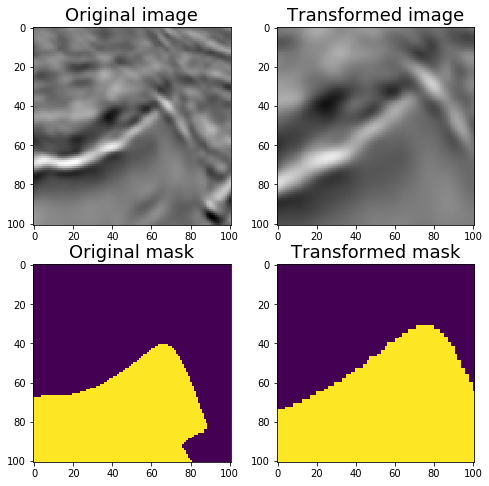

In [18]:
aug = RandomSizedCrop(p=1, min_max_height=(50, 101), height=original_height, width=original_width)

augmented = aug(image=image, mask=mask)

image_scaled = augmented['image']
mask_scaled = augmented['mask']

visualize(image_scaled, mask_scaled, original_image=image, original_mask=mask)

# Let's try to combine different transformations

Light non destructive augmentations.

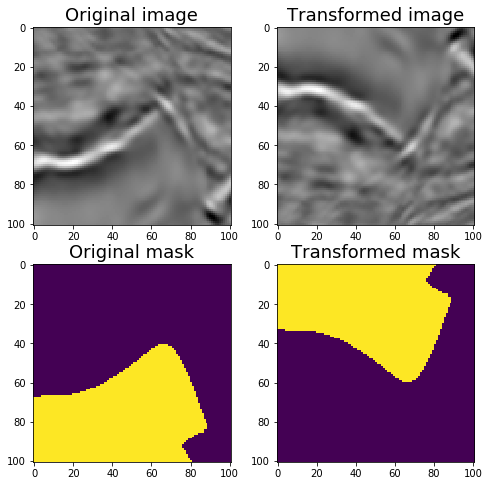

In [19]:
aug = Compose([VerticalFlip(p=0.5),              
              RandomRotate90(p=0.5)])

augmented = aug(image=image, mask=mask)

image_light = augmented['image']
mask_light = augmented['mask']

visualize(image_light, mask_light, original_image=image, original_mask=mask)

# Let's add non rigid transformations and RandomSizedCrop

## Medium augmentations

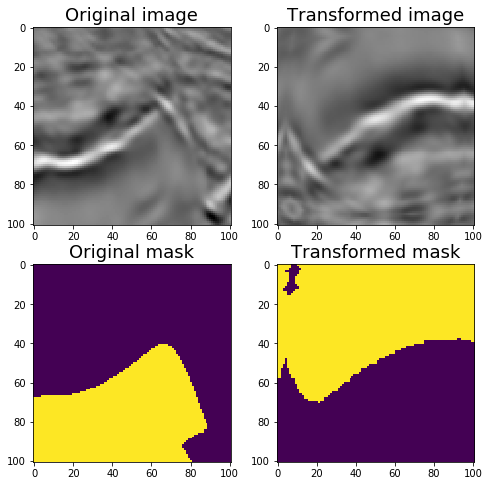

In [20]:
aug = Compose([
    OneOf([RandomSizedCrop(min_max_height=(50, 101), height=original_height, width=original_width, p=0.5),
          PadIfNeeded(min_height=original_height, min_width=original_width, p=0.5)], p=1),    
    VerticalFlip(p=0.5),              
    RandomRotate90(p=0.5),
    OneOf([
        ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(p=0.5),
        OpticalDistortion(p=1, distort_limit=1, shift_limit=0.5)                  
        ], p=0.8)])

augmented = aug(image=image, mask=mask)

image_medium = augmented['image']
mask_medium = augmented['mask']

visualize(image_medium, mask_medium, original_image=image, original_mask=mask)

# Let's add non-spatial stransformations.

Many non spatial transformations like [CLAHE](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.CLAHE), [RandomBrightness](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomBrightness), [RandomContrast](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomContrast), [RandomGamma](https://albumentations.readthedocs.io/en/latest/api/augmentations.html#albumentations.augmentations.transforms.RandomGamma) can be also added. They will be applied only to the image and not the mask.

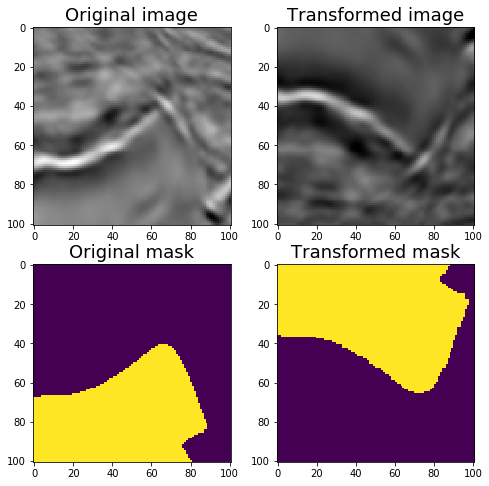

In [23]:
aug = Compose([
    OneOf([RandomSizedCrop(min_max_height=(50, 101), height=original_height, width=original_width, p=0.5),
          PadIfNeeded(min_height=original_height, min_width=original_width, p=0.5)], p=1),    
    VerticalFlip(p=0.5),              
    RandomRotate90(p=0.5),
    OneOf([
        ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(p=0.5),
        OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        ], p=0.8),
    CLAHE(p=0.8),
    RandomContrast(p=0.8),
    RandomBrightness(p=0.8),
    RandomGamma(p=0.8)])

augmented = aug(image=image, mask=mask)

image_heavy = augmented['image']
mask_heavy = augmented['mask']

visualize(image_heavy, mask_heavy, original_image=image, original_mask=mask)